### Introduction

In this notebook we analyze the AirBnB rental properties located in the city of Boston, MA. We are interested in questions related to availabilty and the pricing of properties.

Specific questions we are interested in investigating are:

   * How does the availability vary across months? Are there certain months when availability is high or low?
   * Is there a difference in availability between weekdays vs weekends?

   * How does the price vary across different months?
   * What property types are expensive to rent?
   * What are the least expensive and most expensive neighbourhoods in the Boston area?

Finally we build a model to predict the price of a rental property. We use two algorithms to build the prediction model,Lasso Regression and RandomForest Regression.


#### Let us first import the required libraries

In [435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display_html 
import datetime as dt

 #### Load the data to panda's dataframe

In [436]:
dfb_cal = pd.read_csv('../data/boston_calendar.csv')
dfb_list = pd.read_csv('../data/boston_listings.csv')

#### Check the dimensions of the dataset

In [437]:
dfb_list.shape, dfb_cal.shape

((3585, 95), (1308890, 4))

#### Print the first few rows of the listing data set

In [438]:
dfb_list.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.3


We see that the listings dataset, dfb_list, has 3585 rows and 95 columns, each row correspondig to a listing.

Lets print all the columns to get an idea of what features are available for a listing

In [439]:
np.sort(dfb_list.columns.values)

array(['access', 'accommodates', 'amenities', 'availability_30',
       'availability_365', 'availability_60', 'availability_90',
       'bathrooms', 'bed_type', 'bedrooms', 'beds',
       'calculated_host_listings_count', 'calendar_last_scraped',
       'calendar_updated', 'cancellation_policy', 'city', 'cleaning_fee',
       'country', 'country_code', 'description', 'experiences_offered',
       'extra_people', 'first_review', 'guests_included',
       'has_availability', 'host_about', 'host_acceptance_rate',
       'host_has_profile_pic', 'host_id', 'host_identity_verified',
       'host_is_superhost', 'host_listings_count', 'host_location',
       'host_name', 'host_neighbourhood', 'host_picture_url',
       'host_response_rate', 'host_response_time', 'host_since',
       'host_thumbnail_url', 'host_total_listings_count', 'host_url',
       'host_verifications', 'house_rules', 'id', 'instant_bookable',
       'interaction', 'is_location_exact', 'jurisdiction_names',
       'last_re

#### Print few rows from the calendar data set

In [440]:
dfb_cal.sample(5)

,listing_id,date,available,price
716665,11016623,2016-10-31,f,NaN
902949,951476,2016-10-24,t,$359.00
1206859,8310653,2017-02-14,f,NaN
159789,1471308,2017-09-03,t,$70.00
481387,13592,2016-10-23,t,$465.00


The calendar dataset, dfb_cal, specifies if a listing is available for a given date and if available the price for the day

#### We will use the calendar dataset to investigate the questions related to the availability patterns

First let us check the quality of the data, and clean the data if required

Check if the data has any columns with missing values

In [441]:
dfb_cal.isna().sum()

listing_id         0
date               0
available          0
price         665853
dtype: int64

The output shows that the price column has 66,5853 missing values

In [442]:
display(dfb_cal[dfb_cal['price'].isna()]['available'].unique())
display(dfb_cal[~dfb_cal['price'].isna()]['available'].unique())

array(['f'], dtype=object)

array(['t'], dtype=object)

The above output shows us that the price column has missing values for the listings which are not available (available = f)

Lets check the datatypes of the columns

In [443]:
dfb_cal.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [444]:
dfb_cal['price'].unique()

array([nan, '$65.00', '$75.00', ..., '$1,030.00', '$2,895.00', '$11.00'],
      dtype=object)

The output shows that the price is not numeric and has some special chracters

We will replace these characters and convert the price to a numeric value:

In [445]:
def convert_numeric(val):
    """
    The function removes special characters from feature values 
    that are numeric in nature, and converts these values to float. 
    
    Some examples of such features are price, cleaning_fee, security_deposit etc.,
    which contain special characters such as '$', '%' etc.
    
    Parameters:
    val (str) : value associated with a feature
    
    Returns:
    float : The modified value with special characters removed and converted to float
    """
    
    if not pd.isnull(val):
        chars = ['$', ',', '%']
        for c in chars:
            val = val.replace(c, '')
       
    return float(val)

In [446]:
df_cal = dfb_cal.copy()
df_cal['price'] = df_cal['price'].apply(convert_numeric)

Next, lets extract the month and the year from the date column:

In [447]:
df_cal['date'] = pd.to_datetime(df_cal['date'])
df_cal['month'] = df_cal['date'].dt.month
df_cal['year'] = df_cal['date'].dt.year

Check the time period for which the data is available

In [448]:
df_cal.groupby('year')['month'].value_counts()

year  month
2016  10       111166
      12       111166
      11       107580
      9         89650
2017  1        111166
      3        111166
      5        111166
      7        111166
      8        111166
      4        107580
      6        107580
      2        100408
      9         17930
Name: month, dtype: int64

We see that the data is available for 2016, for the months from September to December, and for 2017 for the months from January to September.

Check the distinct values associated with the 'available' field:

In [449]:
df_cal['available'].value_counts()

f    665853
t    643037
Name: available, dtype: int64

We will convert these to boolean, the value True inidcating the listing is available for the given date:

In [450]:
df_cal['available'] = df_cal['available'] == 't'
df_cal['available'].value_counts()

False    665853
True     643037
Name: available, dtype: int64

#### Lets now investigate on the availability patterns
##### Lets first check the monthly availability pattern

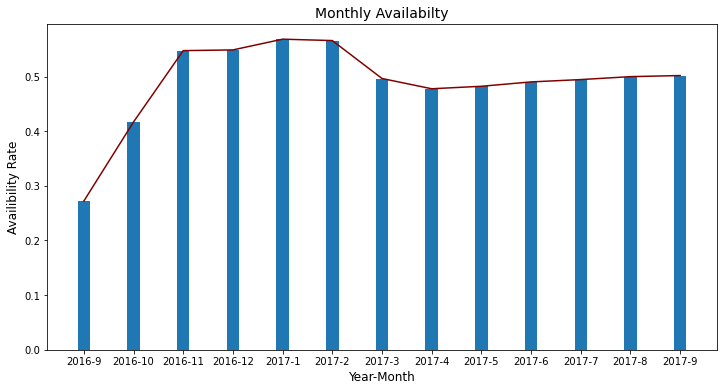

In [451]:
s1= df_cal.groupby(['year', 'month'])['available'].mean()
s1.index = s1.index.map('{0[0]}-{0[1]}'.format)

plt.figure(figsize=(12,6))
plt.title('Monthly Availabilty', fontsize=14)

plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Availibility Rate', fontsize=12)

plt.bar(s1.index, s1.values, width=0.25)
plt.plot(s1.index, s1.values, color='maroon')

* The 'Monthly Availability' plot shows an increase in availibilty from September 2016 to November 2016. 
* The availability pattern seems to be steady around December 2016, and then shows an increasing trend for Jaunuary and February 2017.
* The availabilty dropped in March and April 2017, and after April 2017 the plot shows an increasing trend in availibility.

#### Let us check the availability for weekdays and weekends
#### In order to do this we will create a new column 'wknd' based on the day of the week

In [452]:
def is_weekend(dtime):
    """
    The function is used to add a new feature 'wknd' to the dataframe based on 
    the existing feature 'date'.
    
    The new feature indicates if the date falls on a weekday or a weekend,
    and is created based on numeric value of the day of the week, extracted
    from the date using the weekday() method.
    
    Parameters:
    dtime (datetime) : The value associated with the 'date' feature of the dataframe
    
    Returns:
    str : The return value is either 'Weekend' or 'Weekday'
    """
    
    day = dtime.weekday()
    if day in (5,6):
        return 'Weekend'
    else:
        return 'Weekday'

df_cal['wknd'] = df_cal['date'].apply(is_weekend)

In [453]:
s2 = df_cal.groupby('wknd')['available'].mean()

<BarContainer object of 2 artists>

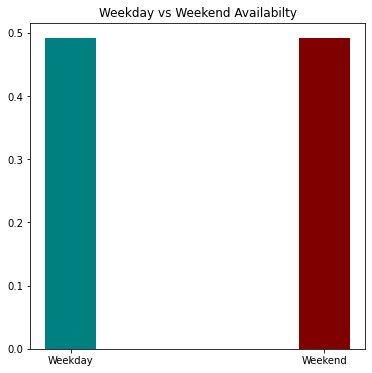

In [454]:
plt.figure(figsize=(6, 6))
plt.title('Weekday vs Weekend Availabilty')
c = ['teal', 'maroon']
plt.bar(s2.index, s2.values, width=0.2, color=c)

The barchart does not show any significant difference in the availability between weekdays and weekends.

#### How does the price vary across different months

<BarContainer object of 13 artists>

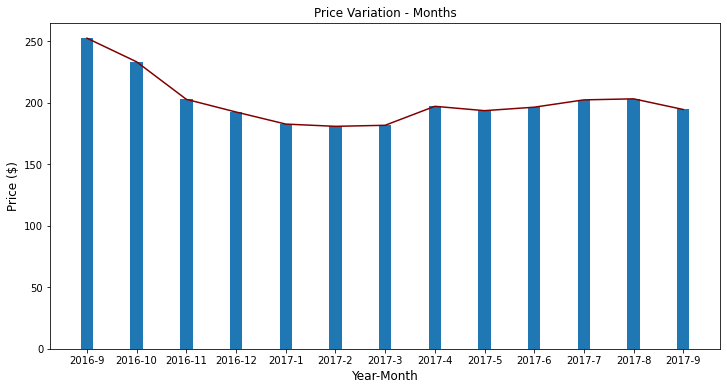

In [455]:
s3= df_cal.groupby(['year', 'month'])['price'].mean()
s3.index = s3.index.map('{0[0]}-{0[1]}'.format)

plt.figure(figsize=(12,6))

plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.title('Price Variation - Months', fontsize=12)
plt.plot(s3.index, s3.values, color='maroon')
plt.bar(s3.index, s3.values, width=0.25)

#### Is there any change in the weekend vs weekday price

In [456]:
s = df_cal.groupby('wknd')['price'].mean()
s

wknd
Weekday    197.498522
Weekend    200.797939
Name: price, dtype: float64

<BarContainer object of 2 artists>

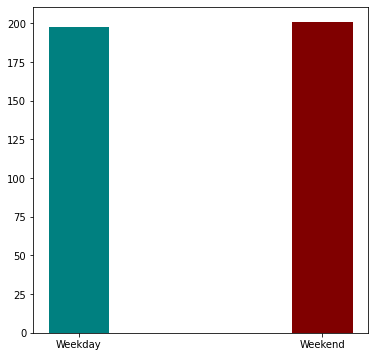

In [457]:
plt.figure(figsize=(6, 6))
c = ['teal', 'maroon']
plt.bar(s.index, s.values, width=0.25, color=c)

#### Most expensive and least expensive neighbourhoods

We will use the listings data set, dfb_list for this analysis. We know from our previous investigation that the price column has some special characters. 

We will use the 'convert_numeric' function defined earlier to convert the price to numeric:

In [458]:
df_list = dfb_list.copy()
df_list['price'] = df_list['price'].apply(convert_numeric)

In [459]:
d = df_list.groupby('neighbourhood_cleansed')['price'].mean().sort_values().reset_index()
d1 = d.head(5)
d2 = d.tail(5)

In [460]:
d1_styler = d1.style.set_table_attributes("style='display:inline'").set_caption('Least expensive (top-5)')
d2_styler = d2.style.set_table_attributes("style='display:inline'").set_caption('Most expensive (top-5)')

display_html(d1_styler._repr_html_()+d2_styler._repr_html_(), raw=True)

,neighbourhood_cleansed,price
0,Mattapan,75.125000
1,Hyde Park,86.548387
2,Dorchester,91.639405
3,Roslindale,98.428571
4,West Roxbury,107.108696
,neighbourhood_cleansed,price
20,Downtown,236.459302
21,Back Bay,240.950331
22,Leather District,253.600000
23,Bay Village,266.833333


The above two tables show us the top-5 least expensive and the top-5 most expensive neighbourhoods.

Lets plot a bar chart to compare all the neighbourhoods side by side

<AxesSubplot:title={'center':'Price - Neighbourhood'}, xlabel='Neighbourhood', ylabel='Price'>

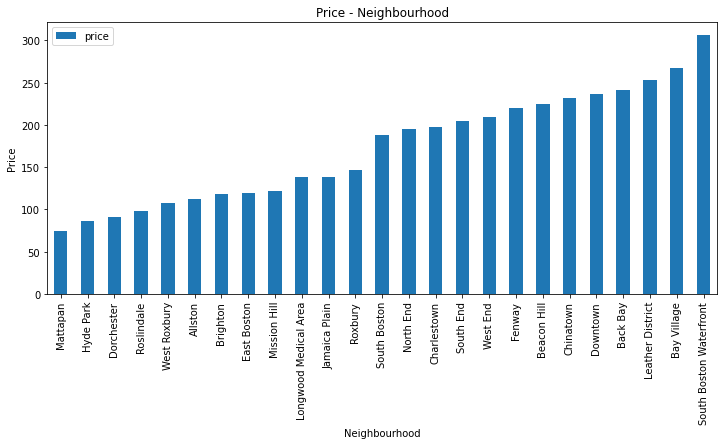

In [461]:
d.plot(kind='bar', x='neighbourhood_cleansed', y='price', figsize=(12, 5), xlabel='Neighbourhood', \
       ylabel='Price', title='Price - Neighbourhood')

#### Using the latitude and longitude features, lets plot a map to identify the location of the neighbouhoods in the Boston area

In [462]:
def calc_price(nbd):
    """
    The function is used to add a new feature 'nbhd_price' to the dataframe based on 
    the exisiting feature 'neighbourhood_cleansed'.
    
    The new feature specifies the average price associated with the neighborhood.
    
    Parameters:
    nbd (str) : The value associated with the 'neighbourhood_cleansed' feature
    
    Returns:
    float : The average price of the neighborhood
    """
    
    if not pd.isnull(nbd):
       return(d[ d['neighbourhood_cleansed']==nbd ]['price'].values[0])


df_list['nbhd_price'] = df_list['neighbourhood_cleansed'].apply(calc_price)

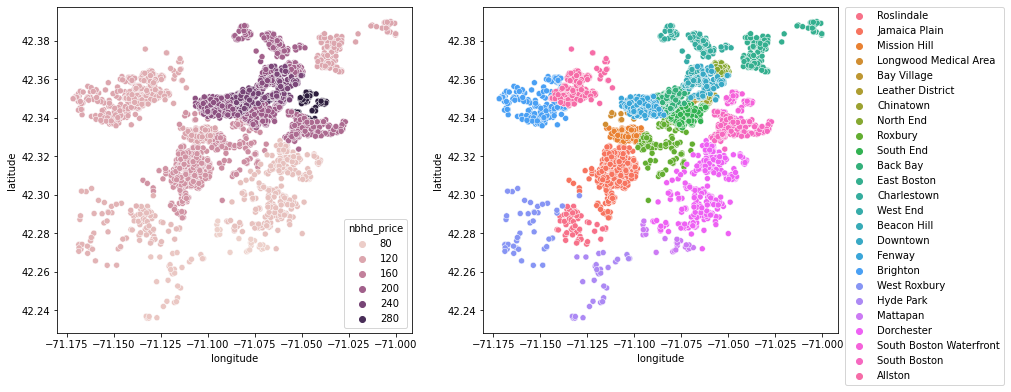

In [463]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(14,6))

sns.scatterplot(data=df_list,x="longitude", y="latitude", hue='nbhd_price', ax=ax1)
sns.scatterplot(data=df_list,x="longitude", y="latitude", hue='neighbourhood_cleansed', ax=ax2)

ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#### Next, lets investigate which property types are the most expenseve and which are least expensive

In [464]:
s = df_list.groupby('property_type')['price'].mean().sort_values(ascending=False).reset_index()

<AxesSubplot:title={'center':'Price - Property Type'}, xlabel='Property Type', ylabel='Price'>

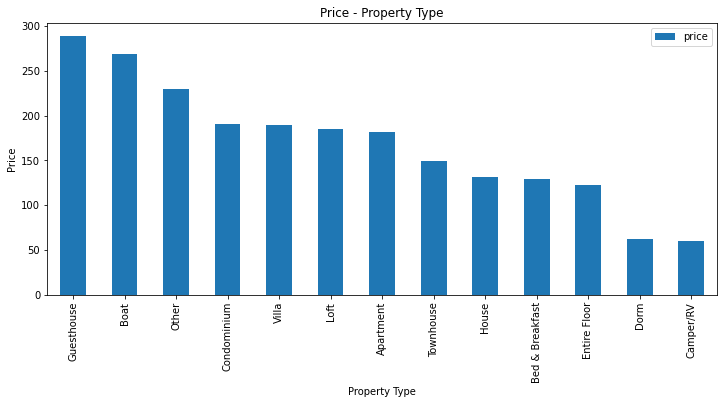

In [465]:
s.plot(kind='bar', x='property_type', y='price', figsize=(12, 5), xlabel='Property Type', \
       ylabel='Price', title='Price - Property Type')

From the above output we see that  Camper/RV, Dorm are some of the least expensive property types to rent, whereas Boat, Guesthouse are some of the most expsnsive properties to rent.

#### Building a Predictive Model

We use two regression algorithms to build the prediction model, Lasso Regression and RandomForest Regression.

Let us first check how many coumns have more than 75% missing values, and if any, we will drop these columns.

In [466]:
drop_cols = dfb_list.columns[dfb_list.isnull().sum()/len(dfb_list)>0.75].values
display(drop_cols)
if len(drop_cols) > 0:
    df = dfb_list.drop(columns=drop_cols)
else:
    df = dfb_list.copy()

array(['neighbourhood_group_cleansed', 'square_feet', 'weekly_price',
       'monthly_price', 'has_availability', 'license',
       'jurisdiction_names'], dtype=object)

Let us check the categorical features available in the data set:

In [467]:
df.select_dtypes(exclude=np.number).columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'calendar_last_scraped',
       'first_review', 'last_review', 'requires_li

Let us check the numerical features available in the data set:

In [468]:
df.select_dtypes(include=np.number).columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

Next, we will drop the features which are id, url based, which are descriptive in nature and which appear to be redundant.

In [469]:
drop_cols = ['scrape_id', 'host_id', 'listing_url', 'last_scraped', 'name', 'summary', 'space', 'calendar_last_scraped', 'neighbourhood',
'description', 'experiences_offered', 'neighborhood_overview', 'notes','transit', 'access', 'interaction', 'street', 'country_code',
'host_neighbourhood','house_rules', 'thumbnail_url', 'host_thumbnail_url', 'host_url', 'host_picture_url', 'market', 'city', 'state', 
'country','smart_location','zipcode', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_location', 
'host_verifications', 'amenities', 'first_review', 'last_review', 'calendar_updated', 'host_since']

df.drop(columns=drop_cols, inplace=True)

Next, we will convert the columns which are numeric in nature but contain special characters like '$', '%' to float. 

We will use the function 'convert_numeric' defined earlier for this conversion:

In [470]:
df['host_response_rate'] = df['host_response_rate'].apply(convert_numeric)
df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(convert_numeric)
df['price'] = df['price'].apply(convert_numeric)
df['cleaning_fee'] = df['cleaning_fee'].apply(convert_numeric)
df['security_deposit'] = df['security_deposit'].apply(convert_numeric)
df['extra_people'] = df['extra_people'].apply(convert_numeric)

Let's plot a correlation matrix for the numerical features:

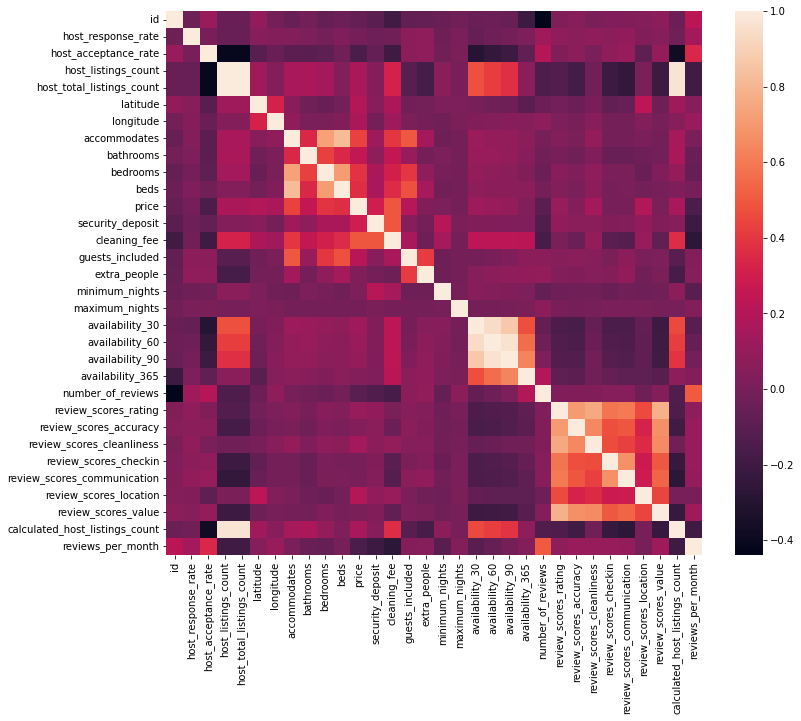

In [471]:
plt.subplots(figsize=(12,10))
sns.heatmap(df.corr());

The correlation matrix shows there are some predictors which are highly correlated with each other. 

We will drop the features which have corelation coeficient > 0.75 

In [472]:
drop_cols = set()
cm = df.corr().abs()
for i in range(cm.shape[1]):
    l = set(cm[cm.iloc[:,i].values > 0.75].index[1:].values)
    if len(l) > 0:
        drop_cols.update(l)
display(drop_cols)

df.drop(columns=drop_cols, inplace=True)

{'availability_60',
 'availability_90',
 'beds',
 'calculated_host_listings_count',
 'host_total_listings_count',
 'review_scores_cleanliness',
 'review_scores_value'}

Lets check the distribution of the numeric features using histogram plots:

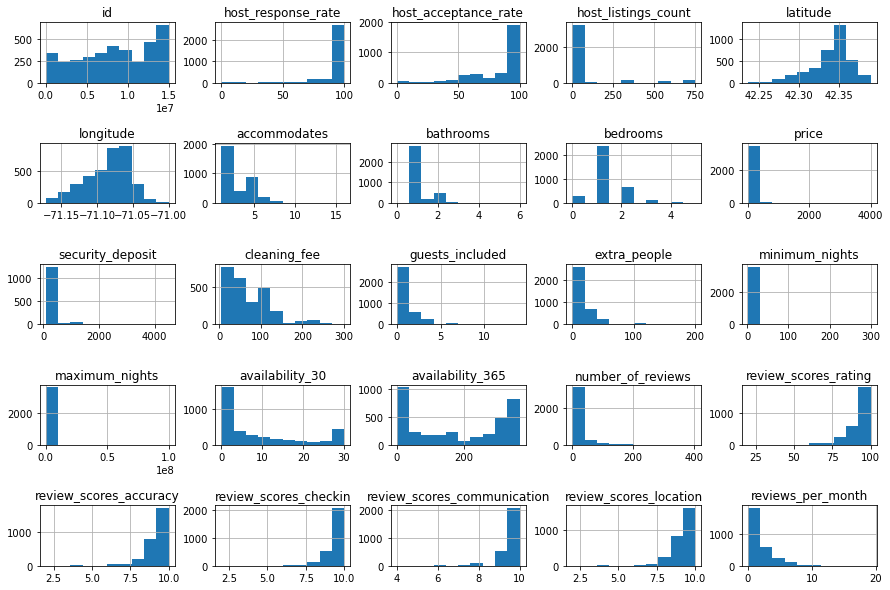

In [473]:
df.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=1.0);

The plot shows that there are quite a few features such as 'accomodates', 'bedrooms', 'price' etc. which are  skewed to the right.

Before we proceed with fitting and evaluating the models, we will first convert the categorical features to dummy variables using the pandas `get_dummies` method.

We will also impute the missing values in the numerical features using the mean value for each feature.

In [474]:
num_vars = df.select_dtypes(include=np.number).columns
cat_vars = df.select_dtypes(exclude=np.number).columns.values

In [475]:
def process_features(df):
    """
    The function is used to apply pre-processig measures to the features of the dataframe.
    
    The function imputes the missing values in the numerical features using the mean.
    The function converts categorical features to dummy variables.
    
    
    Parameters:
    df (DataFrame) : The input dataframe for which the features need pre-processing.
    
    Returns:
    DataFrame : The modified dataframe.
    """
    
    #Impute the mssing values in the numerical features using mean
    for col in num_vars:
       df[col].fillna((df[col].mean()), inplace=True)
    
    #Convert categorical features to dummy variables
    df = pd.get_dummies(df, columns=cat_vars, drop_first=True)
    
    return df

df = process_features(df)

We saw earlier that the target variable price, and a number of other features are skewed to the right, we will use log transformation to normalize these features

In [406]:
s1 = ['accommodates', 'bathrooms', 'bedrooms', 'cleaning_fee', 'extra_people', 'availability_30', 'maximum_nights', 'minimum_nights',
'availability_365', 'guests_included', 'number_of_reviews', 'reviews_per_month', 'host_listings_count', 'security_deposit', 'price']

for x in s1:
    df[x] = np.log(df[x]+1)


Split the data set into training and test data sets:

In [407]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price'), 
                                                    df.price, test_size=0.3, 
                                                    random_state=41)

In [408]:
X_train.shape, X_test.shape

((2509, 79), (1076, 79))

In [409]:
y_train.shape, y_test.shape

((2509,), (1076,))

We saw earlier that the target variable price is skewed to the right, we will use log transformation to normalize the price variable:

#### Train and Test Lasso Regression

We will first create a pipeline object using the StandardScaler() transformer, and the Lasso() estimator.

In [410]:
lasso_pipe = make_pipeline(
    StandardScaler(),
    Lasso()
)

We will use GridSearchCV along with cross-validation to select the regularization paramter that best fits the model.

In [411]:
grid_params = {
         'lasso__alpha': np.arange(0.001, 0.002, 0.0001)
}

In [412]:
lasso_grid_cv = GridSearchCV(lasso_pipe, grid_params, cv=10, n_jobs=-1)

In [413]:
lasso_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017,
       0.0018, 0.0019])})

In [414]:
lasso_grid_cv.best_params_

{'lasso__alpha': 0.0019000000000000004}

In [415]:
coefs = lasso_grid_cv.best_estimator_.named_steps.lasso.coef_
features = X_train.columns
slas = pd.Series(coefs, index=features).sort_values(ascending=False)

#slas = slas[slas.values == 0]
#d1 = slas.to_frame()
l = len(slas)
d1 = slas[0:int(l/4)].to_frame()
d2 = slas[int(l/4):int(l/2)].to_frame()
d3 = slas[int(l/2):int((3*l)/4)].to_frame()
d4 = slas[int((3*l)/4):].to_frame()


In [416]:
d1_styler = d1.style.set_table_attributes("style='display:inline'")

d2_styler = d2.style.set_table_attributes("style='display:inline'")
d3_styler = d3.style.set_table_attributes("style='display:inline'")
d4_styler = d4.style.set_table_attributes("style='display:inline'")


display_html(d1_styler._repr_html_()+d2_styler._repr_html_()+d3_styler._repr_html_()+d4_styler._repr_html_(), raw=True)

,0
accommodates,0.166289
longitude,0.109257
neighbourhood_cleansed_Back Bay,0.084897
bedrooms,0.083087
neighbourhood_cleansed_Fenway,0.072475
latitude,0.071950
availability_30,0.065117
neighbourhood_cleansed_South End,0.063416
neighbourhood_cleansed_Beacon Hill,0.058871
cleaning_fee,0.041277


The root mean square error (RMSE) and mean absolute error (MAE) for the trainig and test datasets are computed below. 

Since we had appplied the log transoformation on the target variable, we will apply the inverse of the log transoformation to get the root mean square error.


The RMSE for the training dataset:

In [417]:
lasso_rmse_train = mean_squared_error(np.exp(y_train), np.exp(lasso_grid_cv.best_estimator_.predict(X_train)), squared=False)
display(np.round(lasso_rmse_train, 4))

129.0135

The MAE for the training dataset:

In [418]:
lasso_mae_train = mean_absolute_error(np.exp(y_train), np.exp(lasso_grid_cv.best_estimator_.predict(X_train)))
display(np.round(lasso_mae_train, 4))

47.4829

The RMSE for the test dataset:

In [419]:
lasso_rmse_test = mean_squared_error(np.exp(y_test), np.exp(lasso_grid_cv.best_estimator_.predict(X_test)), squared=False)
display(np.round(lasso_rmse_test, 4))

74.5434

In [420]:
lasso_mae_test = mean_absolute_error(np.exp(y_test), np.exp(lasso_grid_cv.best_estimator_.predict(X_test)))
display(np.round(lasso_mae_test, 4))

41.0257

##### Results for the Lasso Regression model

* The Root Mean Squared Error for the training data set: 129.01
* The Mean Absolute Error for the training data set: 47.48
* The Root Mean Squared Error for the test data set: 74.54
* The Mean Absolute Error for the test data set: 41.02

#### Train and Test RandomForest Regression¶

We will first create a pipeline object using the StandardScaler() transformer, and the RandomForestRegressor() estimator.

In [421]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=41)
)

We will use GridSearchCV along with cross-validation to select the best estimator for the number of trees.

In [422]:
grid_params = {
        'randomforestregressor__n_estimators': [10, 50, 100],
        'standardscaler': [StandardScaler(), None],
}

In [423]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=10, n_jobs=-1)

In [424]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=41))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 50, 100],
                         'standardscaler': [StandardScaler(), None]})

In [425]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 100,
 'standardscaler': StandardScaler()}

In [426]:
y_train_pred = rf_grid_cv.best_estimator_.predict(X_train)
display(y_train_pred)

array([5.54528603, 5.37307136, 4.23984164, ..., 4.65118323, 5.36774999,
       5.97501718])

The root mean square error (RMSE) for the training dataset:

In [427]:
mean_squared_error(np.exp(y_train.values), np.exp(y_train_pred), squared=False)

76.5079134485929

In [428]:
mean_absolute_error(np.exp(y_train.values), np.exp(y_train_pred))

18.781735248233822

The root mean square error (RMSE) for the test dataset:

In [429]:
mean_squared_error(np.exp(y_test), np.exp(y_test_pred), squared=False)

75.88762246848847

In [430]:
mean_absolute_error(np.exp(y_test.values), np.exp(y_test_pred))

39.16793311872083

##### Results for the RandomForest Regression model

* The Root Mean Squared Error for the training data set: 76.50
* The Mean Absolute Error for the training data set: 18.78
* The Root Mean Squared Error for the test data set: 75.88
* The Mean Absolute Error for the training data set: 39.16

#### Conclusion

* In this notebook we analyzed the AirBnB data set for the Boston area. In particular, we looked into questions related to availability and pricing of the AirBnB rental properties in the area.
* Based on the investigations conducted, we were able to plot the monthly availaibity and price charts, compare between weekday vs weekend availability, compare and plot the variation in price across different neighbourhoods.
* We  built a couple of regression models using  Lasso regression and RandomForest Regression to predict the rent of a property.